Total files found: 400

Tumor file sample:
File: UPENN-GBM-00303_11_T1.nii.gz
Volume shape (should be Axial view, e.g., (X, Y, Z)):  (240, 240, 155)

Non-Tumor file sample:
File: IXI330-Guys-0881-T1.nii.gz
Volume shape (should be Axial view, e.g., (X, Y, Z)):  (150, 256, 256)


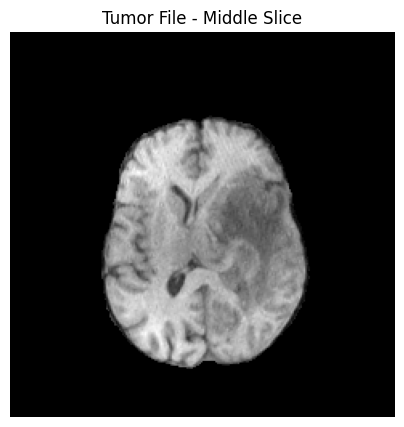

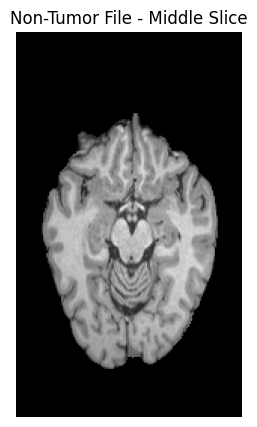

In [1]:
# Step 1: Import Libraries and Define File-Loading Functions

import os
import nibabel as nib
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import random

def load_file_list(tumor_dir, non_tumor_dir):
    """
    Scans the tumor and non-tumor directories for NIfTI files 
    (.nii or .nii.gz) and returns a list of (file_path, label) tuples.
    Label 1 for tumor, 0 for non-tumor.
    """
    file_label_list = []
    
    # Tumor files, labeled as 1
    for file in os.listdir(tumor_dir):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(tumor_dir, file), 1))
            
    # Non-tumor files, labeled as 0
    for file in os.listdir(non_tumor_dir):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_label_list.append((os.path.join(non_tumor_dir, file), 0))
            
    return file_label_list

def load_volume_in_axial(file_path):
    """
    Loads a NIfTI file and reorients it to canonical (RAS) orientation.
    For T1 MRI, canonical orientation is expected to be axial.
    
    If the volume is 4D (e.g., has an extra time dimension), it takes the first timepoint.
    Returns: 3D numpy array representing the volume.
    """
    img = nib.load(file_path)
    
    # Reorient the image to canonical (RAS) using nibabel.
    # This generally converts the image to a standard orientation (usually axial for T1 scans).
    img_canonical = nib.as_closest_canonical(img)
    
    # Get the image data.
    data = img_canonical.get_fdata()
    
    # If the volume is 4D, take the first timepoint.
    if data.ndim == 4:
        data = data[..., 0]
    
    return data

# Example usage:
tumor_folder = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Tumour Data"
non_tumor_folder = r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Non Tumour Data"

file_label_list = load_file_list(tumor_folder, non_tumor_folder)
print(f"Total files found: {len(file_label_list)}")

# Let's verify the orientation and shape of 2 random files (one tumor and one non-tumor)
random_tumor = random.choice([f for f, lbl in file_label_list if lbl == 1])
random_non_tumor = random.choice([f for f, lbl in file_label_list if lbl == 0])

print("\nTumor file sample:")
tumor_volume = load_volume_in_axial(random_tumor)
print(f"File: {os.path.basename(random_tumor)}")
print("Volume shape (should be Axial view, e.g., (X, Y, Z)): ", tumor_volume.shape)

print("\nNon-Tumor file sample:")
non_tumor_volume = load_volume_in_axial(random_non_tumor)
print(f"File: {os.path.basename(random_non_tumor)}")
print("Volume shape (should be Axial view, e.g., (X, Y, Z)): ", non_tumor_volume.shape)

# Optionally, visualize the middle slice of these volumes to ensure axial view.
def visualize_middle_slice(volume, title="Middle Slice"):
    num_slices = volume.shape[2]
    middle = num_slices // 2
    slice_img = volume[:, :, middle]
    # Normalize slice for display
    slice_norm = (slice_img - np.min(slice_img)) / (np.ptp(slice_img)) * 255
    slice_norm = slice_norm.astype(np.uint8)
    
    plt.figure(figsize=(5,5))
    plt.imshow(slice_norm.T, cmap='gray', origin='lower')
    plt.title(title)
    plt.axis("off")
    plt.show()

visualize_middle_slice(tumor_volume, title="Tumor File - Middle Slice")
visualize_middle_slice(non_tumor_volume, title="Non-Tumor File - Middle Slice")

In [2]:
class RepeatChannels:
    """Convert a [1,H,W] tensor to [3,H,W] by repeating the single channel."""
    def __call__(self, x):
        return x.repeat(3, 1, 1)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class TumourSliceDataset(Dataset):
    def __init__(self, file_label_list, transform=None):
        """
        file_label_list: list of (file_path, label) tuples
        transform: torchvision transforms to apply to each slice
        """
        self.file_label_list = file_label_list
        self.transform = transform

    def __len__(self):
        return len(self.file_label_list)

    def __getitem__(self, idx):
        file_path, label = self.file_label_list[idx]
        # Load full 3D volume 
        vol = load_volume_in_axial(file_path)  # -> numpy array, shape (X,Y,Z)
        
        # Pick central axial slice
        z_mid = vol.shape[2] // 2
        slice_2d = vol[:, :, z_mid]

        # Normalize intensities to [0,255]
        slice_norm = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())
        slice_uint8 = (slice_norm * 255).astype(np.uint8)

        # Convert to PIL Image for transforms
        img = Image.fromarray(slice_uint8).convert("L")

        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


class RepeatChannels:
    """Convert a [1,H,W] tensor to [3,H,W] by repeating the single channel."""
    def __call__(self, x):
        return x.repeat(3, 1, 1)

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),       # -> [1,224,224]
    RepeatChannels(),            # -> [3,224,224]
    transforms.Normalize(        
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


file_label_list = load_file_list(
    r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Tumour Data",
    r"C:\Users\Devshree Deshmukh\OneDrive\Desktop\MSc Project\BraTS_ML_Project\data\Non Tumour Data"
)

# Instantiate dataset
dataset = TumourSliceDataset(file_label_list, transform=transform)

# Split into train/val and create DataLoaders
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1) Small Custom CNN
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 224×224 → 224×224
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # 224 → 112

            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # 112 → 56

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # 56 → 28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate
small_cnn = SmallCNN(num_classes=2)

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm  # for progress bars

# 1) Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
small_cnn = small_cnn.to(device)

# 2) Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_cnn.parameters(), lr=1e-3, weight_decay=1e-5)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects / total_samples
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val  ", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_corrects / total_samples
    return epoch_loss, epoch_acc

# 3) Run Training for N Epochs with Early Stopping
num_epochs = 30
patience = 5
best_val_acc = 0.0
epochs_no_improve = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(small_cnn, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = validate(small_cnn, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(small_cnn.state_dict(), "best_small_cnn.pth")
        print(f"→ New best model saved (Val Acc: {best_val_acc:.4f})")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"Stopping early after {epoch} epochs without improvement.")
        break

print("Training complete. Best Val Acc: ", best_val_acc)

Epoch 01 | Train Loss: 1.3241, Train Acc: 0.8656 | Val Loss:   0.1709, Val Acc:   0.9500
→ New best model saved (Val Acc: 0.9500)


Epoch 02 | Train Loss: 0.0163, Train Acc: 0.9938 | Val Loss:   0.0000, Val Acc:   1.0000
→ New best model saved (Val Acc: 1.0000)


Epoch 03 | Train Loss: 0.0032, Train Acc: 0.9969 | Val Loss:   0.0000, Val Acc:   1.0000
No improvement for 1 epoch(s)


Epoch 04 | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss:   0.0000, Val Acc:   1.0000
No improvement for 2 epoch(s)


Epoch 05 | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss:   0.0000, Val Acc:   1.0000
No improvement for 3 epoch(s)


Epoch 06 | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss:   0.0000, Val Acc:   1.0000
No improvement for 4 epoch(s)


Epoch 07 | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss:   0.0000, Val Acc:   1.0000
No improvement for 5 epoch(s)
Stopping early after 7 epochs without improvement.
Training complete. Best Val Acc:  1.0


In [6]:
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

# 1) Load the best checkpoint
small_cnn.load_state_dict(torch.load("best_small_cnn.pth"))
small_cnn.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = small_cnn(imgs)
        probs = torch.softmax(logits, dim=1)[:, 1]  # prob of “tumour” class
        preds = (probs > 0.5).long().cpu()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# 2) Metrics
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Non-tumour","Tumour"])
auc = roc_auc_score(all_labels, all_probs)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print(f"\nROC AUC: {auc:.4f}")

Confusion Matrix:
 [[37  0]
 [ 0 43]]

Classification Report:
               precision    recall  f1-score   support

  Non-tumour       1.00      1.00      1.00        37
      Tumour       1.00      1.00      1.00        43

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


ROC AUC: 1.0000


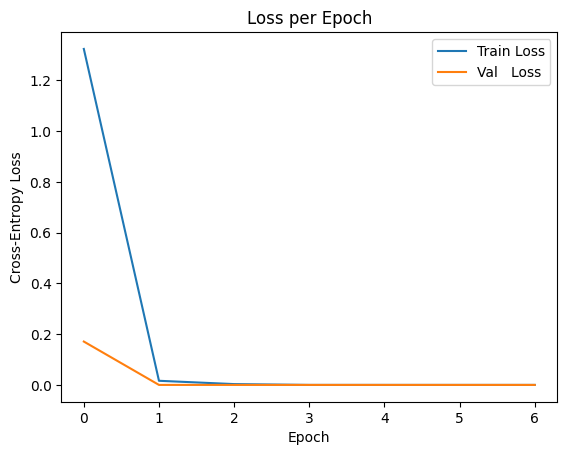

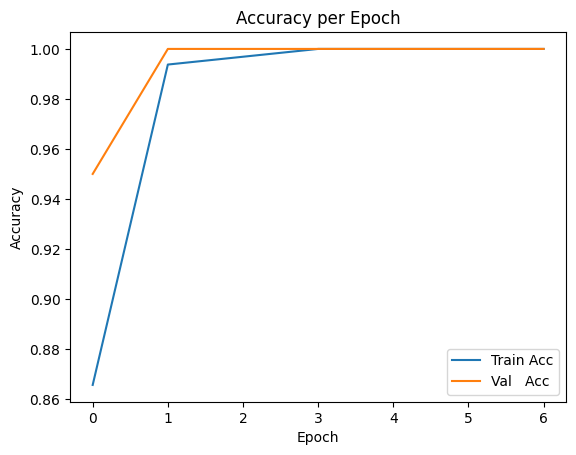

In [7]:
import matplotlib.pyplot as plt

# 1) Loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val   Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.show()

# 2) Accuracy curves
plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs,   label="Val   Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_file_labels = file_label_list 

fold = 1
for train_idx, val_idx in kf.split(all_file_labels):
    print(f"=== Fold {fold} ===")
    train_list = [all_file_labels[i] for i in train_idx]
    val_list   = [all_file_labels[i] for i in val_idx]

    train_ds = TumourSliceDataset(train_list, transform=transform)
    val_ds   = TumourSliceDataset(val_list,   transform=transform)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)

    # reinitialize model, optimizer, early stopping counters…
    model = SmallCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    best_acc, epochs_no_imp = 0.0, 0

    # Same early-stop loop (max 30 epochs, patience=5)
    for epoch in range(1, 31):
        train_one_epoch(model, train_loader, optimizer, criterion, device)
        _, val_acc = validate(model, val_loader, criterion, device)
        # …early stopping logic…
        if epochs_no_imp >= 5:
            break

    print(f"Fold {fold} best val acc: {best_acc:.4f}")
    fold += 1

=== Fold 1 ===


Fold 1 best val acc: 0.0000
=== Fold 2 ===


Fold 2 best val acc: 0.0000
=== Fold 3 ===


Fold 3 best val acc: 0.0000
=== Fold 4 ===


Fold 4 best val acc: 0.0000
=== Fold 5 ===


Fold 5 best val acc: 0.0000


In [14]:
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(small_cnn, dummy_input, "smallcnn.onnx", opset_version=11)